# Imports

Cargamos todas las librerías y funciones necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from geopy.distance import geodesic
from itertools import combinations
from Levenshtein import distance

%run functions_airbnb.ipynb

# Carga de datos

Cargamos los datos de Airbnb

In [2]:

df = pd.read_csv("AirBnB2clean.csv")

# Procesamiento de datos

Esta parte será dividida en dos. La primera para obtener insight general sobre a qué nos enfrentamos, y la segunda para obtener los detalles solicitados, usando de marco la primera parte.

1. Información general del dataset

2. Análisis particular por columna

3. Limpieza del dataframe

4. Reporte estadístico

## Información general del dataset

In [3]:
print(f"El tamaño original del dataframe de items es de {df.shape[0]} filas y {df.shape[1]} columnas")
print()

print(f"El dataset cuenta con {df.duplicated(keep=False).sum()} columnas duplicadas")

El tamaño original del dataframe de items es de 48895 filas y 16 columnas

El dataset cuenta con 0 columnas duplicadas


In [4]:
df.info()        # Tipos de datos, nulls, memoria usada


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  object 
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Se pueden ver unos cuantos datos nulos. Estos datos serán tratados más adelante, luego de procesar las columnas individualmente.

Con esta información y un sample de los datos, podemos hacernos una idea inicial de las características de cada columna (su relevancia, si son ordinales, y si sus estadísticas son o no relevantes)

In [5]:
df.sample(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
35205,6292,Cozy Apartment off J&M Subway Lines,16304,Alisha,Brooklyn,-,40.70051,-73.93909,Entire home/apt,125 Dollars,1,12,2017-09-26,0.38,1,0
39787,1493,Large 2 Story 2 Bedroom Corner Unit On Top Floor,46147,Joshua,BROOKLYN,Bushwick,40.69901,-73.93649,Entire home/apt,$ 175,20,11,2018-10-09,0.32,3,0
33370,11774,Spacious bedroom in Astoria,15132,Sam,QUEENS,Astoria,40.77238,-73.92446,Private room,53 Do.,3,2,2018-12-29,0.22,1,0
23564,50104,"1st Fl Studio on Upper East, close to Central ...",32971,Nikki,Manhattan,Upper East Side,40.77096,-73.95334,Entire home/apt,125,7,3,2018-05-31,0.21,1,0
47379,20098,Cozy 1 bedroom w/twin bed & futon in Park Slope,34005,Pedro & Jeff,BROKLYN/NY,-,40.66154,-73.98685,Private room,USD 49,3,2,2019-06-29,1.62,1,30
22466,8525,Luxury Studio Apartment with private outdoor s...,6228,Kendra,Brooklyn,Crown Heights,40.67902,-73.96101,Entire home/apt,USD 97,5,2,2016-10-31,0.04,1,0
18187,50025,Cozy BR | Private Floor & Terrace,63311,Tal,BROKLYN/NY,-,40.67859,-73.96076,Private room,75,1,117,2019-06-24,2.82,1,96
5026,29277,Big 3 Bedroom Garden Level Apartment Near Subway,63520,Sasha,Bronx,Claremont Village,40.83507,-73.91040,Entire home/apt,72 Dollars,90,2,2018-04-23,0.12,7,223
27265,43997,Cozy & Affordable Room in 3 Story Brownstone,14401,Martita,BROKLYN/NY,Bedford-Stuyvesant,40.68613,-73.92950,Private room,$ 100,1,1,2019-04-23,0.39,6,356
6406,37225,Spacious 1-bedroom flat in LES,17202,Stavros,MANHATTAN,Chinatown,40.71601,-73.99171,Entire home/apt,$ 130,4,2,2018-04-09,0.10,1,0


### De aquí ya podemos ir extrayendo información a tener en cuenta:

* Cómo es de esperarse, __id__ y __host_id__ son enteros ordinales, pero sin relevancia ordinal ni estadística ya que son tags de identificación.

* __name__ es una columna de strings con caracteres alfanuméricos y compuesto por varias palabras.

* Los __host_name__ son nombres propios, y deberían coincidir con los __host_id__.

* __neighbourhood_group__ son nombres propios, aparentemente bastante sucios. Con mayúsculas, abreviaciones, errores de ortografía, y algunos alfanuméricos.

* __neighbourhood__ parece presentar elementos vacíos. Es posible que también tenga errores similares a los de la columna anterior.


* __latitude__ y __longitude__ deberían ser números reales acotados, así que un análisis estadístico es necesario para detectar anomalías. También parece haber cierto grado de suciedad respecto a sus cifras significativas.

* __room_type__ contiene caracteres alfanuméricos.

* __price__ tiene indicaciones de precio, escrito en varios formatos distintos. Requerira un análisis de la forma del string, y luego una análisis estadístico para encontrar anomalías.

* Las __minimum_nights__ son números enteros. Realizar análisis estadístico para detectar anomalías.

* __last_review__ contiene strings de fechas. Contiene missing values, y hay que chequear luego si tiene algún formato de datetime.

* __reviews_per_month__ son floats con missing values. Analizar estadísticas para ver anomalías.

* __calculated_host_listings_count__ son números enteros. Analizar estadísticas.

* __availability_365__ debería estar compuestas con números enteros entre 0 y 365 (chequear posibles 366 si hay años bisiestos en la data).

Por último, antes de pasar a análisis más detallados, podemos ver la función describe. Aunque según lo que mencioné antes, muchos de los datos carecen de relevancia.

In [6]:
df.describe()


,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,32722.414439,32564.904264,40.728949,-73.952170,7.029962,23.274466,1.373221,7.143982,112.781327
std,18978.126745,18889.550994,0.054530,0.046157,20.510550,44.550582,1.680442,32.952519,131.622289
min,0.000000,0.000000,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000
25%,16254.000000,16119.000000,40.690100,-73.983070,1.000000,1.000000,0.190000,1.000000,0.000000
50%,32751.000000,32234.000000,40.723070,-73.955680,3.000000,5.000000,0.720000,1.000000,45.000000
75%,49137.000000,49086.000000,40.763115,-73.936275,5.000000,24.000000,2.020000,2.000000,227.000000
max,65536.000000,65534.000000,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000


* __id__ y __host_id__ se ven razonables. A priori la única cosa que enucentro extraño es la diferencia de 2 entre los valores máximos. Pero no parece ser algo muy relevante.

* __latitude__ y __longitude__ se encuentran dentro de los parámetros razonables 

* __minimum_nights__ tiene problemas en su valor máximo

* __number_of_reviews__, __reviews_per_month__, y __calculated_host_listings__ son razonables.

* __availability_365__ tiene valores 0, lo cual es extraño, pero podría deberse a que la vivienda esté ocupada durante todo el año. No obstante, sería razonable prestarle atención.

## Análisis particular

### Columna 1: ID

Esta columna es un identificador. Uno esperaría no encontrar valores cero (salvo potencialmente el primero), ni nulos, ni repetidos. Recordemos que el tamaño del dataframe es de 48895 filas.

In [7]:
n_valores_unicos_id = len(df['id'].unique())

print(f"El dataframe tiene {n_valores_unicos_id} valores únicos.")

print(f"Hay una diferencia de {df.shape[0] - n_valores_unicos_id} valores respecto a lo esperado.")

El dataframe tiene 34617 valores únicos.
Hay una diferencia de 14278 valores respecto a lo esperado.


Veamos qué pasa en los valores que se repiten:

In [8]:
df[df.duplicated('id', keep=False)].sort_values('id')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
24072,6,A Living Room,25546,Syeda,Queens,Briarwood,40.70579,-73.81001,Shared room,$ 30,1,10,2019-06-11,4.05,9,361
14171,6,Presidential Comfort,8358,Cathy,Queens,Far Rockaway,40.60395,-73.74904,Private room,$ 55,1,27,2019-07-07,2.21,1,177
30154,11,XTRA LARGE 1 Bedroom Gramercy Apt,46800,Lindsay,MANHATTAN,Kips Bay,40.73879,-73.98226,Entire home/apt,749 Dollars,1,0,NaN,NaN,1,0
15678,11,Cozy Private Room in Upper Manhattan,22268,Stephanie,MANHATTAN,East Harlem,40.79741,-73.93493,Private room,120,1,3,2018-09-19,0.22,2,179
12265,11,"Pvt Single Bed 10 min from JFK, Close to Manha...",16893,Melissa,QUEENS,-,40.71711,-73.75608,Private room,$ 55,2,7,2019-05-22,0.76,2,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21019,65521,Comfortable & independent apartment in Queens NY,56052,Kevin,Queens,East Elmhurst,40.75888,-73.87889,Entire home/apt,$ 120,1,0,NaN,NaN,1,264
4096,65524,Sonder | Stock Exchange | Cozy 1BR + Laundry,24667,Sonder (NYC),Manhattan,Financial District,40.70710,-74.01194,Entire home/apt,$230,2,6,2019-06-20,2.28,327,327
46547,65524,Kosher new studio close to subway,42138,Jacob,Broo.,Bensonhurst,40.61576,-73.99166,Private room,125 Dollars,2,4,2018-04-11,0.07,2,0
44399,65530,East Manhattan (March 10th-18th),36428,Jenn,MANHATTAN,East Village,40.72636,-73.98231,Private room,USD 70,4,2,2017-03-10,0.05,1,0


A priori no parece haber una correlación entre los __id__ repetidos y las otras columnas. Por lo tanto, sería adecuado indicarle al cliente esta inconsistencia en los datos originales. 

Viendo el sample, y recordando que no hay filas duplicadas, podemos concluir que hubo algún problema en el registro de los datos de los __id__, o algún tipo de cambio en el vínculo de arrendatario con Airbnb. Será tenido en cuenta a la hora de la limpieza de datos.

### Columna 2: NAME

En este caso se buscarán repetidos, nulos, y caracteres extraños. Un análisis más exhaustivo podría recurrir a utilizar modelos de lenguaje para detectar casos extraños o sin sentido, pero escapa un poco del scope del análisis.

In [9]:
print(f"El dataframe cuenta con {len(df[df.duplicated(keep=False)])} elementos duplicados en la columna name")

El dataframe cuenta con 0 elementos duplicados en la columna name


In [10]:
valores_invalidos_name = len(df[valores_invalidos(df['name']) == True])

print(f"Hay {valores_invalidos_name} valores inválidos en la columna name")

Hay 16 valores inválidos en la columna name


Probemos ahora si hay demasiados caracteres raros:

In [11]:
caracteres_raros_name = df[df['name'].str.contains(r"[^a-zA-Z0-9\s.,“”!?|()#’&+-:/\'\"]") == True]
caracteres_raros_name.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
18,52758,**Luxury 1 Bedroom Upper East Side NYC Apt,33914,Kara,Manhattan,-,40.76257,-73.95915,Entire home/apt,$ 249,30,1,2018-01-25,0.06,121,273
60,41272,"★2,200sq Duplex w/Backyard near Fort Greene Park★",36048,Flavia,Brooklyn,Fort Greene,40.69447,-73.97296,Entire home/apt,220 Dollars,6,0,NaN,NaN,1,43
80,9654,Slice of Heaven @ 811,26779,Sharon,BROKLYN/NY,Crown Heights,40.67030,-73.94182,Entire home/apt,250,3,44,2019-07-04,2.33,1,52
106,2517,*NO GUEST SERVICE FEE* Beekman Tower One Bedro...,59132,Red Awning,MANHATTAN,-,40.75238,-73.96653,Entire home/apt,$ 737,3,2,2019-05-23,0.71,49,224
209,48587,✰ Manhattan Bridge ✰ STUDIO / w. Private Backyard,8553,Feliks,MANHATTAN,Chinatown,40.71387,-73.99427,Entire home/apt,155 Dollars,5,0,NaN,NaN,1,165
247,46733,~Luxury 1 bedroom apt. near Columbus Circle,33914,Kara,MANHATTAN,Midtown,40.76528,-73.98175,Entire home/apt,$ 239,30,0,NaN,NaN,121,351
281,45108,☆Massive DUPLEX☆ 2BR & 2BTH East Village 9+ Gu...,32142,Seith,MANHATTAN,East Village,40.72939,-73.98857,Entire home/apt,$189,2,403,2019-07-07,4.10,3,201
291,59255,2 bedrooms available• private garden • 2/5 train,2495,Jenni & Eric,BROKLYN/NY,East Flatbush,40.65241,-73.95088,Private room,80 Dollars,2,51,2019-06-24,5.50,1,34
326,60003,Lovely Vintage Haven—Heart of UWS,43633,Linda & Chris,MANHATTAN,Upper West Side,40.78569,-73.97581,Entire home/apt,USD 175,65,11,2013-10-15,0.12,1,358
329,53471,Spacious Bushwick BR; Yard! ~175ft to Subway,2576,Amos,Brooklyn,Bushwick,40.70518,-73.92165,Private room,USD 65,1,52,2019-06-29,1.70,3,179


In [12]:
print(f"El dataframe presenta {len(caracteres_raros_name)} filas con caracteres raros en name")

El dataframe presenta 2025 filas con caracteres raros en name


El dataframe presenta varias filas con caracteres raros en la columna name. Esto podría ser de importancia para el cliente en caso de análisis futuros (podría generar problemas en el procesamiento).

No obstante, lo más relevante son los 16 valores nulos. Los mismos serán tratados en la limpieza.

No hay valores repetidos en la columna.

### Columna 3 y 4: HOST_ID y HOST_NAME

Estas columnas serán tratadas a la vez, ya que cada host_id debería corresponder únicamente a un host. __host_id__ con dos nombres de host asociados, serán considerados anómalos. Sin embargo, mismo __host_name__ para distintos __host_id__ no son anómalos (ya que puede haber personas con el mismo nombre, pero distintas propiedades).

También se buscarán valores nulos.

In [13]:
valores_invalidos_host_id = len(df[valores_invalidos(df['host_id']) == True])
valores_invalidos_host_name = len(df[valores_invalidos(df['host_name']) == True])

print(f"Hay {valores_invalidos_name} valores inválidos en la columna host_id")
print(f"Hay {valores_invalidos_host_name} valores inválidos en la columna host_name")

Hay 16 valores inválidos en la columna host_id
Hay 27 valores inválidos en la columna host_name


In [14]:
host_conflictos = df.groupby('host_id')['host_name'].nunique()

host_anomalos = host_conflictos[host_conflictos > 1].index

df[df['host_id'].isin(host_anomalos)].sort_values('host_id')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1307,14656,COZY SPOT,1,Melissa & Rondie,Brooklyn,East Flatbush,40.65825,-73.92191,Private room,USD 50,2,41,2018-03-18,1.15,1,250
21097,18742,Big room in Williamsburg Penthouse,1,Gaute,Brooklyn,Williamsburg,40.71160,-73.95210,Private room,USD 79,4,0,NaN,NaN,1,0
38450,38950,Grand apartment on 5th avenue,14,Lauren,Manhattan/NY,Greenwich Village,40.73238,-73.99517,Entire home/apt,300 Dollars,3,0,NaN,NaN,1,0
41004,16420,Upper East Side Studio Apartment,14,Nicole,MANHATTAN,Upper East Side,40.76644,-73.95635,Entire home/apt,99,5,15,2017-05-01,0.45,1,0
43112,52486,"Cozy Master Suite, Sunny & Charming Loft w/ a ...",19,Sophie,BROKLYN/NY,-,40.71827,-73.94381,Private room,USD 90,3,0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,32596,"Huge 3BR Penthouse, Private Roof!",65504,Nick,MANHATTAN,-,40.74422,-73.97822,Entire home/apt,$1550,2,0,NaN,NaN,1,0
31739,16350,2 bedroom/1 bathroom next to Columbia University,65520,Courtney,MANHATTAN,Morningside Heights,40.81214,-73.96488,Entire home/apt,$150,2,2,2019-01-01,0.21,1,0
41738,15561,Welcome to Kensington,65520,Josh,BROOKLYN,Kensington,40.63402,-73.97556,Private room,$ 49,2,6,2016-09-05,0.10,1,0
7195,1411,1 BR minutes from Central Park!,65528,Maria,Manhattan/NY,Upper East Side,40.76158,-73.96031,Private room,80 Dollars,2,10,2017-05-03,0.25,1,0


In [15]:
print(f"Hay {len(host_anomalos)} casos anómalos de distintos hosts para el mismo host_id")

Hay 7330 casos anómalos de distintos hosts para el mismo host_id


Esto es problemático, ya que este podría ser el primer error grave con el que nos encontramos. No obstante, al igual que los __id__, esto se podría deber a cambios en la relación de arrendatario con Airbnb. Se tendrá en cuenta a la hora de la limpieza.

Los 27 valores nulos en la columna host_id serán procesados en la limpieza

### Columna 5 y 6: NEIGHBOURHOOD_GROUP y NEIGHBOURHOOD.

En primera instancia buscaremos valores nulos. Luego se hallará la cantidad de valores únicos y veremos si pueden ser sutituidos a mano. De ser muy grande la cantidad, veremos si hace falta utilizar una distancia (por ejemplo Levenshtein) para corregir.

In [16]:
valores_invalidos_host_neighbourhood = len(df[valores_invalidos(df['neighbourhood']) == True])
valores_invalidos_host_neighbourhood_group= len(df[valores_invalidos(df['neighbourhood_group']) == True])

print(f"Hay {valores_invalidos_host_neighbourhood} valores inválidos en la columna neighbourhood")
print(f"Hay {valores_invalidos_host_neighbourhood_group} valores inválidos en la columna neighbourhood_group")

Hay 11574 valores inválidos en la columna neighbourhood
Hay 0 valores inválidos en la columna neighbourhood_group


Hay muchos valores nulos en la columna neighbourhood que tendrán que ser tratados con cuidado en la limpieza.

Procedamos con los valores únicos:

In [17]:
df["neighbourhood_group"].unique()

array(['BROOKLYN', 'Brooklyn', 'Manhattan', 'MANHATTAN', 'BROKLYN/NY',
       'QUEENS', 'Manhattan/NY', 'Broo.', 'Manh.', 'Queens', 'BRONX',
       'Bronx', 'Queens/NYC', 'MANHATAN', 'STATEN ISLAND',
       'Staten Island', 'ST. ISL.', 'Staten Isl.'], dtype=object)

Son muy pocos los casos que fueron escritos de forma anómala, así que serán corregidos manualmente a la hora de la limpieza de datos.

In [18]:
print(f"Hay {len(df['neighbourhood'].unique())} neighbourhoods únicos")


Hay 220 neighbourhoods únicos


El análisis manual en este caso podría llevarse a cabo, pero se podría automatizar gran parte buscando casos en los que la distancia de Levenshtein sea de 1 o 2. La distancia de Levenshtein busca permutaciones de n caracteres entre los distintos elementos de la lista. Aquellos que tengan una distancia < 3 serán revisados.

In [19]:
n_levenshtein = 2

pares_similares = [(a, b) for a, b in combinations(df['neighbourhood'].unique(), 2) if distance(a, b) <= n_levenshtein]

pares_similares

[('Upper West Side', 'Upper East Side'),
 ('West Village', 'East Village'),
 ('SoHo', 'NoHo')]

Los pares similares son razonables para Levenshtein <= 2.

Cabe destacar que hay valores vacíos marcados con "-". Los mismos serán tenidos en cuenta en la limpieza.

### Columna 7 y 8: LATITUDE y LONGITUDE

Para ver si los datos de latitud y longitud son raros, se buscaran datos vacíos, y se graficaran los mismos a ver si son razonables.

/Users/jyoung/.pyenv/versions/3.9.18/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


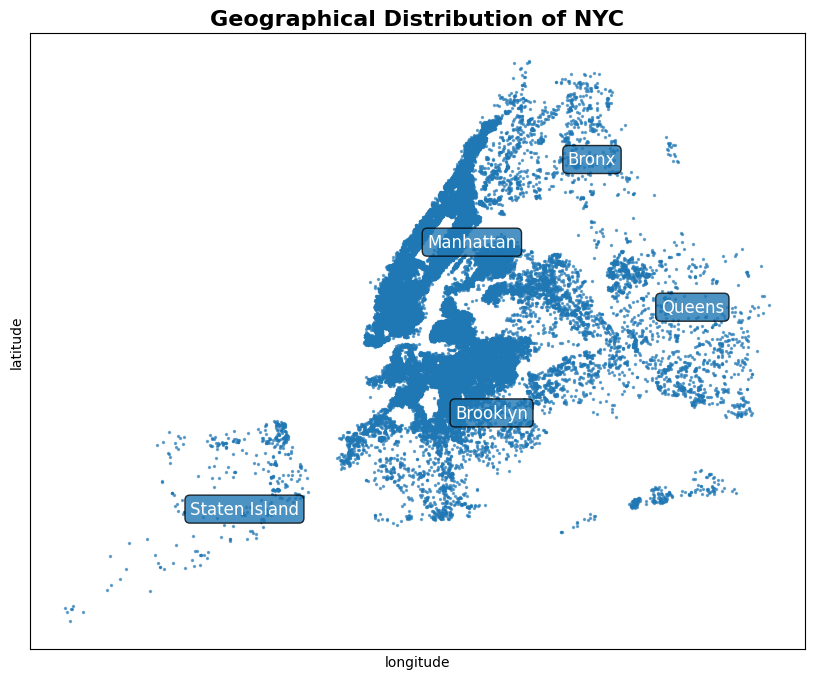

In [20]:
map_ny(df)

Los datos parecen ser razonables.

In [21]:
valores_invalidos_longitude = len(df[valores_invalidos(df['longitude']) == True])
valores_invalidos_latitude= len(df[valores_invalidos(df['latitude']) == True])

print(f"Hay {valores_invalidos_longitude} valores inválidos en la columna longitude")
print(f"Hay {valores_invalidos_latitude} valores inválidos en la columna latitude")

Hay 0 valores inválidos en la columna longitude
Hay 0 valores inválidos en la columna latitude


__latitude__ y __longitude__ no precisan cambios.

### Columna 9: ROOM_TYPE

Para __room_type__ se buscaran valores nulos y valores únicos para detectar anomalías

In [22]:
valores_invalidos_room_type= len(df[valores_invalidos(df['room_type']) == True])

print(f"Hay {valores_invalidos_room_type} valores inválidos en la columna room_type")


Hay 0 valores inválidos en la columna room_type


In [23]:
df["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

__room_type__ no precisa cambios.

### Columna 10: PRICE

Esta columna es fundamental, y bastante particular.

Primero que nada, es un string, pero que nos interesa principalmente el número. Segundo, que hay muchas formas de escribirlo y todas correctas.

La forma más eficiente de tratarlo es verificar que todos los precios se encuentran en dólares, luego extraer su valor, y luego ver su distribución para hallar anomalías.

In [24]:
valores_invalidos_price= len(df[valores_invalidos(df['price']) == True])

print(f"Hay {valores_invalidos_price} valores inválidos en la columna price")

Hay 0 valores inválidos en la columna price


In [25]:
symbols = extraer_no_numerico(df["price"])

print(set(symbols))


{'', 'Do.', 'USD', '$', 'Dollars'}


En efecto, los valores son en dólares.

In [26]:
prices = extraer_numerico(df["price"])

prices_int = [int(x) for x in prices]

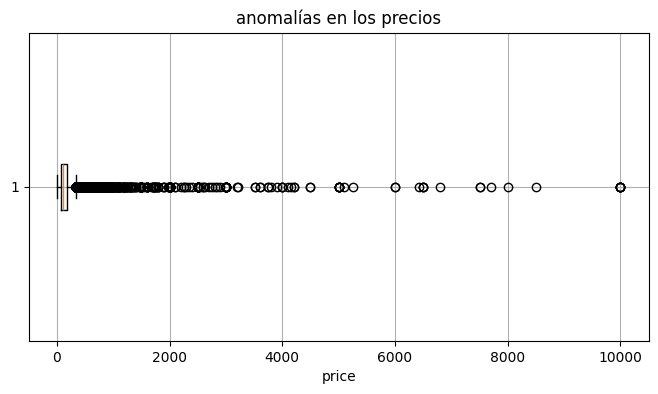

In [27]:
generate_boxplot_from_list(prices_int)

La distribución cuenta con muchos outliers. Pero tras una búsqueda en internet, encontré que hay varios penthouses en Manhattan que tienen valores de 10.000 dólares por noche (o incluso más), así que estos valores son posibles.

Para verificarlo vemos la distribución haciendo un histograma.

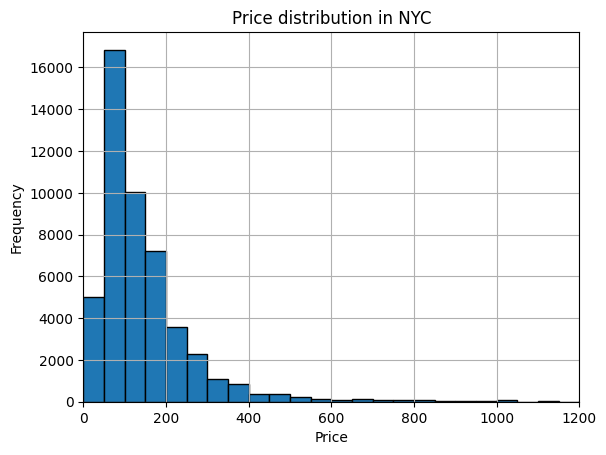

In [28]:

plot_int_histogram(prices_int, 200, 1200)


Se ve razonable, aunque según el boxplot, parecen haber valores iguales a cero. 

In [29]:
valores_cero = [x for x in prices_int if x == 0]

print(f"Hay {len(valores_cero)} valores inválidos en la columna price")

Hay 11 valores inválidos en la columna price


Estos valores serán descartados en la limpieza.

### Columna 11: minimum_nights

Veremos los valores nulos, y su distribución para detectar anomalías.

In [30]:
valores_invalidos_minimum_nights= len(df[valores_invalidos(df['minimum_nights']) == True])

print(f"Hay {valores_invalidos_minimum_nights} valores inválidos en la columna minimum_nights")

Hay 0 valores inválidos en la columna minimum_nights


Buscamos outliers:

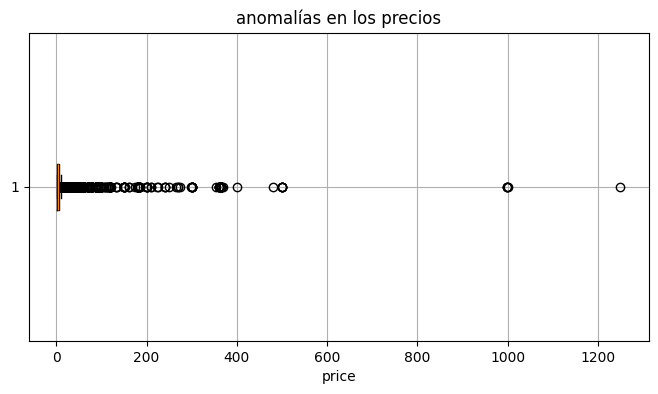

In [31]:
min_nights_list = list(df['minimum_nights'])

generate_boxplot_from_list(min_nights_list)

Hay muchos outliers que claramente no tienen sentido.

Es necesario definir un umbral de corte: Este podrían ser los outliers, pero supongamos que Airbnb permite alquilar hasta un año (exagerando).

In [32]:
plus_one_year =df[df['minimum_nights'] >= 365]

len(plus_one_year)

43

Hay 43 valores que consideraremos anómalos. Veamos el histograma, aunque ya tengamos la info relevante:

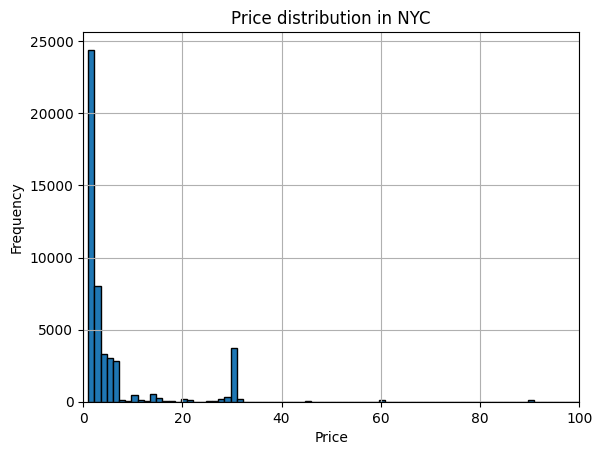

In [33]:
plot_int_histogram(min_nights_list, 1000, 100)


In [34]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,20739,Perfect 2-bedroom in the best part of Williams...,24864,Angelina,BROOKLYN,-,40.71983,-73.96465,Entire home/apt,$ 249,30,0,NaN,NaN,1,0
1,65164,Ditmas park lot,62595,Brian,Brooklyn,Flatbush,40.63809,-73.96445,Private room,$60,2,0,NaN,NaN,1,173
2,23090,Doorman Gym 2 Beds Luxury Building!5211,52328,Jeremy & Laura,Manhattan,Murray Hill,40.74404,-73.97217,Private room,135 Dollars,30,2,2017-03-31,0.07,96,303
3,36673,seagate pravite house 5 mins away from beach,3184,Tural,BROOKLYN,Sea Gate,40.57531,-74.00518,Entire home/apt,USD 99,4,0,NaN,NaN,1,19
4,52600,Sunny & Clean Apt ideal location E.Williamsburg!,43677,Shahar,BROOKLYN,Williamsburg,40.70684,-73.93854,Entire home/apt,$90,7,6,2019-06-07,0.15,2,302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,12511,"大双人房,共用卫生间,",26156,Kelly,Queens/NYC,Flushing,40.75379,-73.83011,Private room,58,3,20,2019-05-27,0.97,3,88
48891,38094,Sunny renovated 1 BR in Brooklyn by Prospect Park,32910,Peter,Broo.,Flatbush,40.64745,-73.96207,Entire home/apt,USD 72,1,15,2019-06-23,3.13,1,1
48892,46029,Beautiful Bright Brooklyn BedRoom *20 Min to C...,10810,Norma-Jean,BROKLYN/NY,Bedford-Stuyvesant,40.67876,-73.91096,Private room,41,2,5,2019-06-16,2.08,2,74
48893,27843,Sunny Bedford Stuyvesant Townhouse,37203,Raymond,BROKLYN/NY,-,40.68576,-73.92211,Entire home/apt,150,1,197,2019-07-01,3.19,3,209


### Columna 12: number_of_reviews

buscamos valores vacíos, y anomalías

In [35]:
valores_invalidos_number_of_reviews= len(df[valores_invalidos(df['number_of_reviews']) == True])

print(f"Hay {valores_invalidos_number_of_reviews} valores inválidos en la columna number_of_reviews")

Hay 0 valores inválidos en la columna number_of_reviews


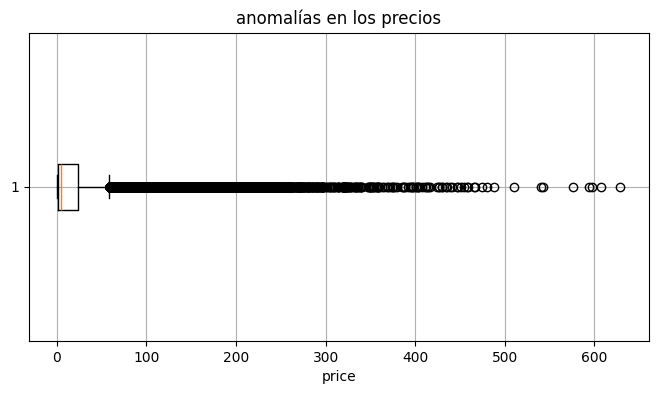

In [36]:
number_of_reviews = list(df['number_of_reviews'])

generate_boxplot_from_list(number_of_reviews)

Los valores parecen razonables.

### Columna 13: number_of_reviews

Aquí buscaremos valores de fechas nulas y/o vacías, así como fechas que escapen de lo razonable.


In [37]:
valores_invalidos_last_review= len(df[valores_invalidos(df['last_review']) == True])

print(f"Hay {valores_invalidos_last_review} valores vacíos en la columna last_review")

Hay 10052 valores vacíos en la columna last_review


Aquellos valores que tengan __number_of_reviews__ = 0, tiene sentido que tengan un __last_review__ vacío.

In [38]:
valores_inconsistentes = df[(df['number_of_reviews'] == 0) & (df['last_review'].notnull())].shape[0]

print(f"Hay {valores_inconsistentes} valores inconsistentes en la columna last_review")

Hay 0 valores inconsistentes en la columna last_review


Por último, chequeemos si hay números mayores a 2025, días mayores a 31, o meses mayores a 12.

In [39]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Filtrar fechas inválidas
fechas_invalidas = df[
    (df['last_review'].dt.year > 2025) |
    (df['last_review'].dt.month > 12) |
    (df['last_review'].dt.day > 31)
]

print(f"Hay {len(fechas_invalidas)} valores inconsistentes en la columna last_review")

Hay 0 valores inconsistentes en la columna last_review


Por lo tanto, no hay problemas en la columna __last_review__.

### Columna 14: REVIEWS_PER_MONTH

El análisis es similar al de number of views, agregando también en análisis de la distribución.

In [40]:
valores_invalidos_reviews_per_month= len(df[valores_invalidos(df['reviews_per_month']) == True])

print(f"Hay {valores_invalidos_reviews_per_month} valores vacíos en la columna reviews_per_month")

valores_invalidos_reviews_per_month = df[(df['number_of_reviews'] == 0) & (df['reviews_per_month'].notnull())].shape[0]

print(f"Hay {valores_invalidos_reviews_per_month} valores inconsistentes en la columna reviews_per_month")

Hay 10052 valores vacíos en la columna reviews_per_month
Hay 0 valores inconsistentes en la columna reviews_per_month


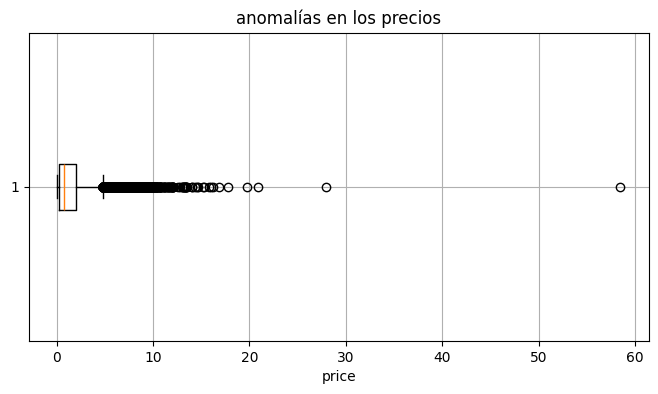

In [41]:
number_of_reviews_per_month = list(df['reviews_per_month'])
lista_sin_nans = [x for x in number_of_reviews_per_month if pd.notna(x)]

generate_boxplot_from_list(lista_sin_nans)

Las cantidades de reviews parecen razonables, pese a los outliers.

### Columna 15: calculated_host_listings

Buscaremos valores vacíos, y anomalías estadísticas. Es necesario revisar también si los nombres de propietarios se repiten a la par de su cantidad de listings.

In [42]:
valores_invalidos_calculated_host_listings_count= len(df[valores_invalidos(df['calculated_host_listings_count']) == True])

print(f"Hay {valores_invalidos_calculated_host_listings_count} valores vacíos en la columna calculated_host_listings_count")

Hay 0 valores vacíos en la columna calculated_host_listings_count


Vemos ahora si hay distintos listings para el mismo host_id. Pero cómo sabemos que hay varios host_name para un mismo host_id, tendremos que agrupar también según host name.

In [43]:
grupo = df.groupby(['host_id', 'host_name'])['calculated_host_listings_count'].nunique()

anomalos = grupo[grupo > 1]

print(f"Hay {len(anomalos)} propietarios con discrepancias en su cantidad de listings")


Hay 3 propietarios con discrepancias en su cantidad de listings


Hay solamente tres casos raros. No es trivial decidiro que hacer con ellos aunque sean pocos, pero propongo que esto se puede deber a :

1. Snapshots temporales del dataset:
    * Si el dataset junta registros de distintos momentos, es posible que el número de listings de un host haya cambiado con el tiempo.

2. Errores o inconsistencias en el scraping:
    * Si los datos fueron obtenidos desde múltiples fuentes o con scrapers distintos, puede haber registros redundantes con diferencias menores.

3. Datos incorrectamente duplicados:
    * Podés tener múltiples filas del mismo listing con valores distintos de calculated_host_listings_count porque cambió entre días y nadie limpió los duplicados.

Se mencionará en la limpieza, pero no será particularmente tenido en cuenta para descartar las filas correspondientes.

### Columna 16: AVAILABILITY_365

Buscaremos valores nulos o vacíos, y veremos la distribución. Ya sabemos que hay unos cuantos valores = 0 los cuales miraremos en detalle.

In [44]:
valores_invalidos_availability_365= len(df[valores_invalidos(df['availability_365']) == True])

print(f"Hay {valores_invalidos_availability_365} valores vacíos en la columna availability_365")

Hay 0 valores vacíos en la columna availability_365


In [45]:
zero_availability = len(df[df["availability_365"] == 0])

print(f"Hay zero availability en {zero_availability} propiedades")

Hay zero availability en 17533 propiedades


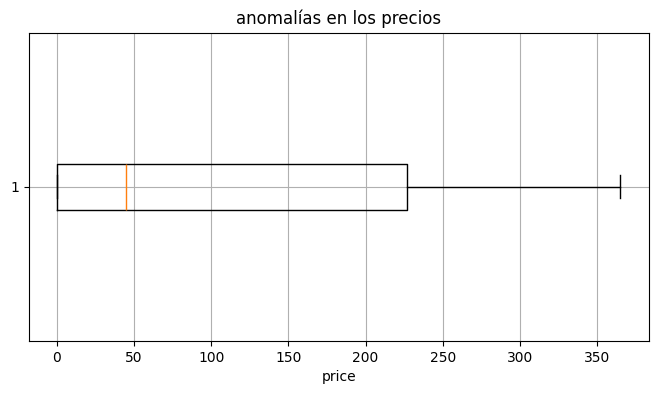

In [46]:
number_of_availability_365 = list(df['availability_365'])
lista_sin_nans = [x for x in number_of_availability_365 if pd.notna(x)]

generate_boxplot_from_list(lista_sin_nans)

Llama la atención la cantidad de propiedades no disponibles, pero es posible que se encuentren todas ocupadas. Lo tendremos en cuenta a la hora de realizar la corrección de los datos.

Veamos un sample del dataframe a ver si podemos explicar esto:

In [47]:
df[df["availability_365"] == 0]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,20739,Perfect 2-bedroom in the best part of Williams...,24864,Angelina,BROOKLYN,-,40.71983,-73.96465,Entire home/apt,$ 249,30,0,NaT,NaN,1,0
7,15432,Gorgeous 1bd in Trendy Brooklyn!,15516,Kaitlin,BROKLYN/NY,Park Slope,40.67655,-73.97303,Entire home/apt,$180,4,4,2018-12-30,0.22,1,0
8,36747,Room w Roof in Trendy Renovated E Williamsburg...,15974,Danite,BROKLYN/NY,Williamsburg,40.70568,-73.94282,Private room,$70,10,2,2018-11-19,0.21,1,0
10,16079,Fresh,31333,Victoria,QUEENS,Fresh Meadows,40.72894,-73.78003,Private room,USD 80,1,2,2019-05-25,1.22,1,0
12,50440,Fashion and Hotel Couple’s Hells Kitchen Apart...,16408,Craig,Manhattan,Hell's Kitchen,40.75803,-73.99853,Entire home/apt,285,3,0,NaT,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48881,43493,Sunny Brick wall bedroom in Lower East Side,23495,Steph,MANHATTAN,Chinatown,40.71449,-73.99094,Private room,$70,5,0,NaT,NaN,1,0
48882,2093,Beautiful light cozy apartment,31968,Carmen,Queens/NYC,-,40.75741,-73.92509,Entire home/apt,125,1,0,NaT,NaN,1,0
48883,29436,HUGE private bedroom in Artists' home in Bushwick,168,Karina,Brooklyn,Bushwick,40.68847,-73.91300,Private room,70 Dollars,1,3,2018-01-01,0.16,2,0
48888,44063,Well lit and modern 1BR condo in LES,15320,Lizzie,MANHATTAN,Chinatown,40.71629,-73.99066,Entire home/apt,USD 175,2,10,2018-10-01,0.54,1,0


A priori no parece haber una correlación entre la availability nula, y el resto de las columnas.

# Limpieza de datos

Del análisis exploratorio anterior hemos logrado sacar varias conclusiones. Ahora las enumeraremos y procederemos a limpiar siguiendo criterios según los insights obtenidos.

### ID 

Esta columna presenta muchos valores duplicados. Esto habría que mencionarlo al cliente (Airbnb) para que revise la calidad de sus datos. No obstante, no descartaremos datos por duplicados, ya que es probable que se trate de snapshots de la data que poseían en distintos momentos.

### NAME

Esta columna contiene varios caracteres extraños como asteriscos, o incluso estrellas. Estos valores no deberían estar en el campo del nombre, ya que podría complicar procesamientos futuros. No obstante, los dejaremos pasar. 
Los 16 valores nulos encontrados serán descartados a continuación:

In [48]:
df_2 = df[df['name'].notnull()]

#Sanity check:
print(f"Valores descartados: {len(df) - len(df_2)}")

Valores descartados: 16


### HOST ID y HOST_NAME

Ambos tienen valores duplicados al tomarlos de a pares. Esto será mencionado, pero en principio no descartaremos datos por ello.

### NEIGHBOURHOOD GROUP

Esta columna cuenta con muchos casos que no están escritos en formato. Para ello recordamos sus ocurrencias y las sobreescribimos de la forma más adecuada.

In [49]:
mapeo = {
    'BROOKLYN': 'Brooklyn',
    'Brooklyn': 'Brooklyn',
    'BROKLYN/NY': 'Brooklyn',
    'Broo.': 'Brooklyn',
    
    'MANHATTAN': 'Manhattan',
    'Manhattan': 'Manhattan',
    'Manhattan/NY': 'Manhattan',
    'Manh.': 'Manhattan',
    'MANHATAN': 'Manhattan',
    
    'QUEENS': 'Queens',
    'Queens': 'Queens',
    'Queens/NYC': 'Queens',
    
    'BRONX': 'Bronx',
    'Bronx': 'Bronx',
    
    'STATEN ISLAND': 'Staten Island',
    'Staten Island': 'Staten Island',
    'ST. ISL.': 'Staten Island',
    'Staten Isl.': 'Staten Island'
}

df_3 = df_2.copy()

df_3['neighbourhood_group'] = df_3['neighbourhood_group'].replace(mapeo)


### NEIGHBOURHOOD

Esta columna cuenta con muchos valores sin rellenar con el símbolo "-". Para rellenarlos se hará la siguiente aproximación:

Primero definiremos las coordenadas de cada barrio como el promedio de las coordenadas de aquellas filas con las que si contamos que pertenecen a ese barrio.

Luego, utilizaremos las coordenadas de la fila sin la data para calcular a cuál centro de barrio es el más cercano. Esta aproximación no es exacta, pero es lo más parecido que se puede hacer sin tener que recurrir a un mapa por barrio de NY.

In [50]:
df_4 = df_3.copy()

# Calculo centroides por barrio usando solo entradas válidas
df_validos = df[df['neighbourhood'] != '-']
centroides = df_validos.groupby('neighbourhood')[['latitude', 'longitude']].mean()

# Detecto los sin rellenar
df_faltantes = df[df['neighbourhood'] == '-']

# Función para hallar el barrio más cercano
def barrio_mas_cercano(lat, lon):
    distancias = centroides.apply(lambda row: geodesic((lat, lon), (row['latitude'], row['longitude'])).meters, axis=1)
    return distancias.idxmin()

# Imputar valores
df_4.loc[df['neighbourhood'] == '-', 'neighbourhood'] = df_faltantes.apply(
    lambda row: barrio_mas_cercano(row['latitude'], row['longitude']), axis=1
)

### LATITUDE & LONGITUDE

Para este caso, ya habiendo analizado que ambas tenían comportamiento adecuado, solamente se hará un redonde de 5 valores luego de la coma.

In [51]:
df_5 = df_4.copy()

df_5['latitude'] = df_4['latitude'].round(5)
df_5['longitude'] = df_4['longitude'].round(5)


### ROOM_TYPE

Nada que cambiar de esta columna

### PRICE

En este caso se normalizaran los precios para convertirlos en un número entero. No se retirarán outliers debido a la posibilidad de que existan alquileres incluso en los precios más altos presentes en el dataset. También se descartarán aquellos valores iguales a cero ya que no tienen sentido.

In [52]:
df_6 = df_5.copy()

df_6['price'] = [int(float(x)) if x != '' else np.nan for x in extraer_numerico(df_5['price'])]

df_6 = df_6[df_6["price"] != 0]


### MINIMUM NIGHTS

En este caso se descartarán outliers

In [53]:
df_7 = df_6[df_6['minimum_nights'] <= 365]

print(f"Valores descartados: {len(df_6) - len(df_7)}")


Valores descartados: 13


### NUMBER OF REVIEWS, LAST REVIEW, REVIEW PER MONTH

Como fue analizado más arriba, estas tres columnas están en orden.

### CALCULATED LISTINGS

Calculated listings presenta el mismo problema que __host_id__, pero como fue mencionado más arriba, no se descartará.

### AVAILABILITY 365

En este caso no hay valores vacíos, pero si hay una cantidad alarmante de datos con valor cero. No obstante, ante la interrogante sobre qué hacer, seguiré la consigna y me limitaré a cambiar los valores vacíos, que en este caso no hay ninguno.


## DATAFRAME FINAL:

In [54]:
df_final = df_7.copy()

# Reporte estadístico

En la última parte de la consigna se solicita:

4. Generar un reporte gráfico con los precios por barrios/zonas de la ciudad.
    1. Generar una visualización gráfica de los precios
    2. Generar estadísticas por barrio, precio máximo, mínimo, promedio, mediano
    3. Generar estadísticas por grupos de barrios, precio máximo, mínimo, promedio, mediano
    4. ¿Cuál es la completitud de los datos que pudo utilizar para las últimas dos partes? ¿Puede mejorarla de alguna manera? 

La parte 1 ya fue realizada en el análisis particular de la columna price. Allí se pueden ver las gráficas de histograma y boxplot con outliers referentes al precio.

La parte 4 ya fue hecha en la limpieza, al hacer la aproximación por centroides de los barrios faltantes.

Falta hacer la parte 2 y 3.

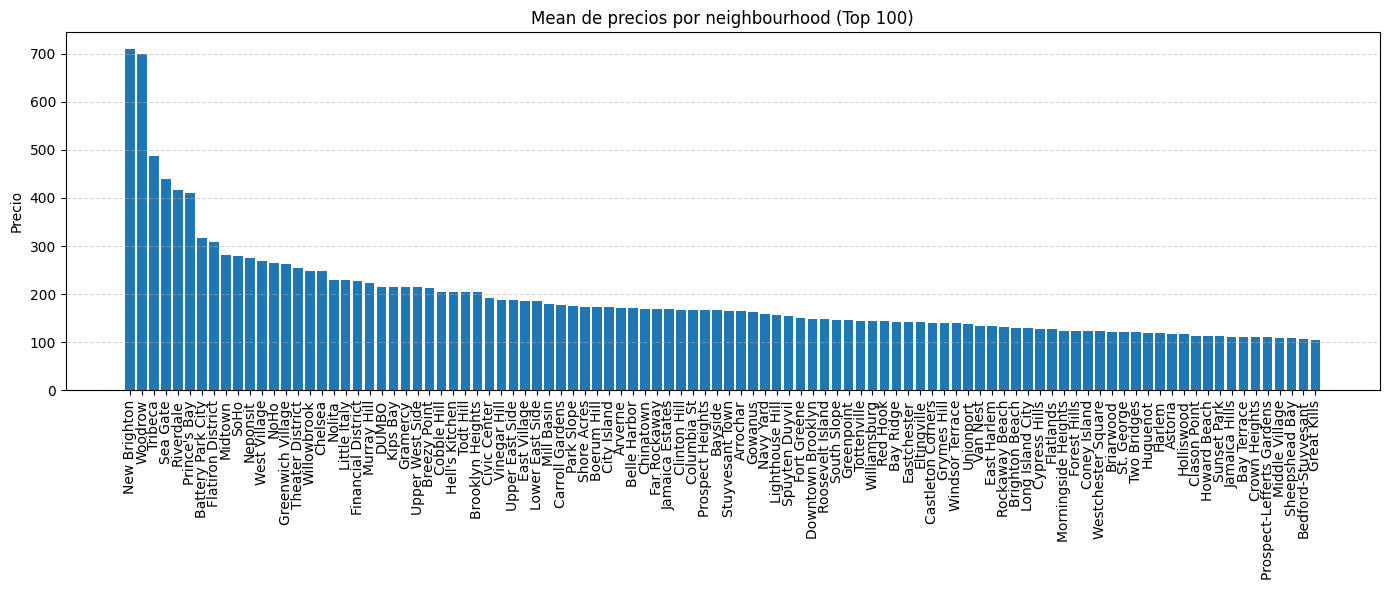

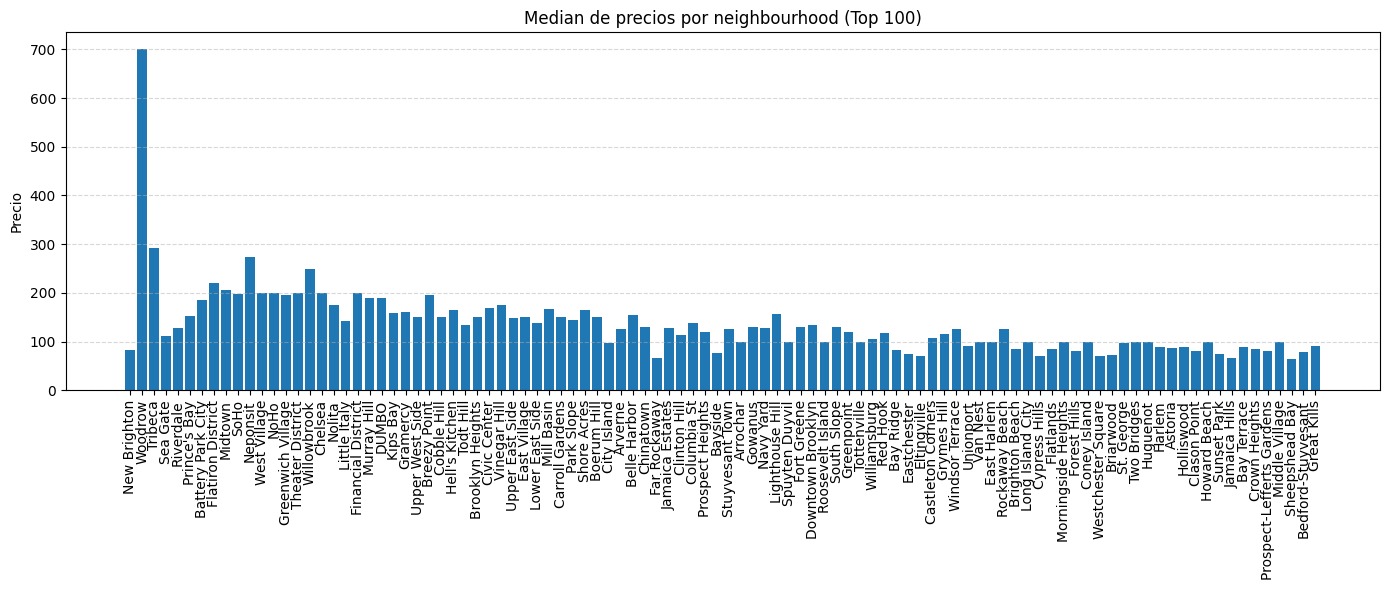

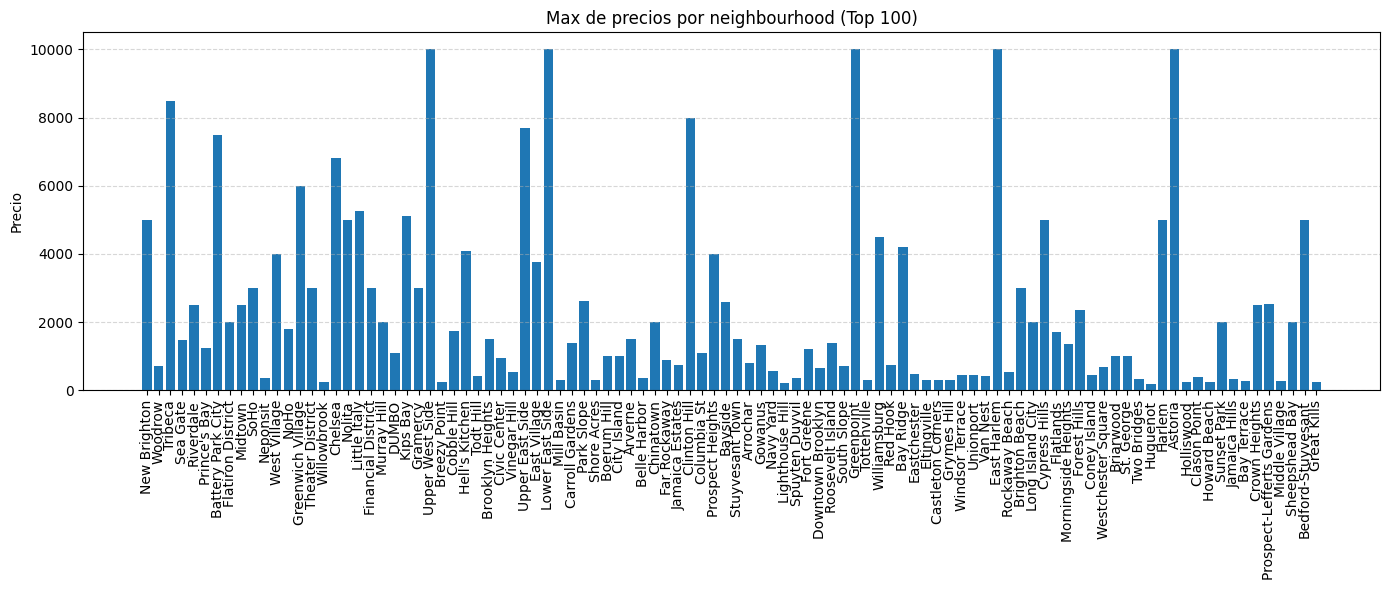

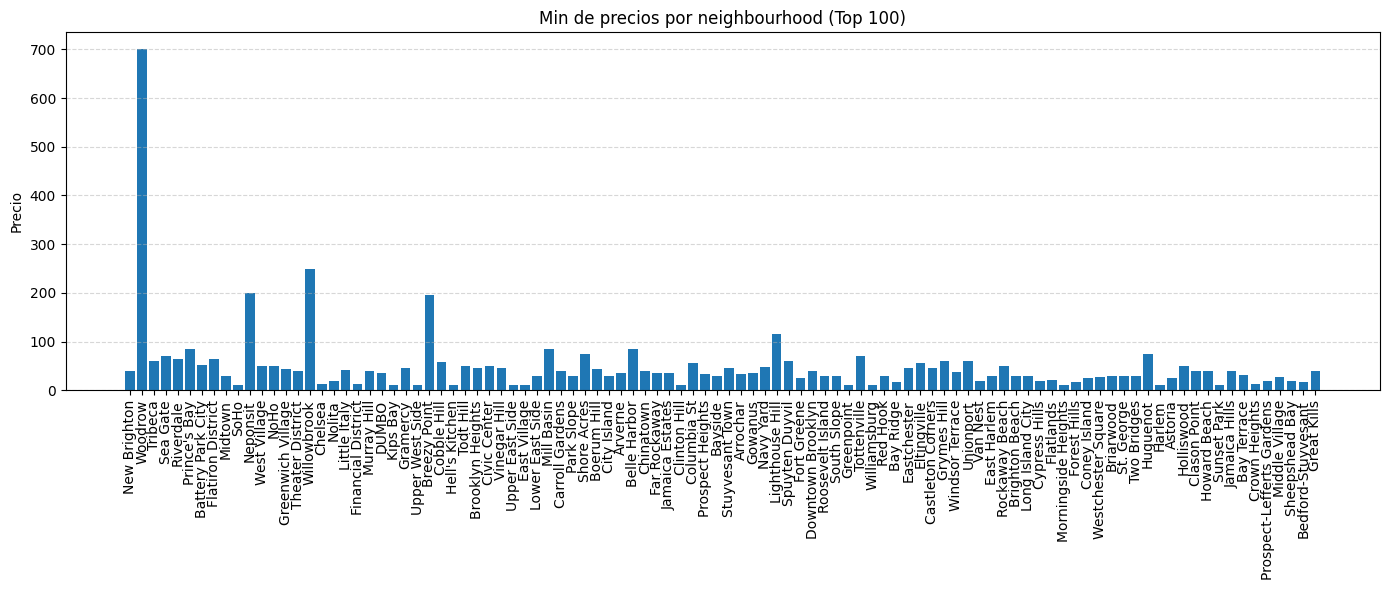

In [55]:
plot_price_stats(df_final, 'neighbourhood')


Ahora para neighbourhood group:

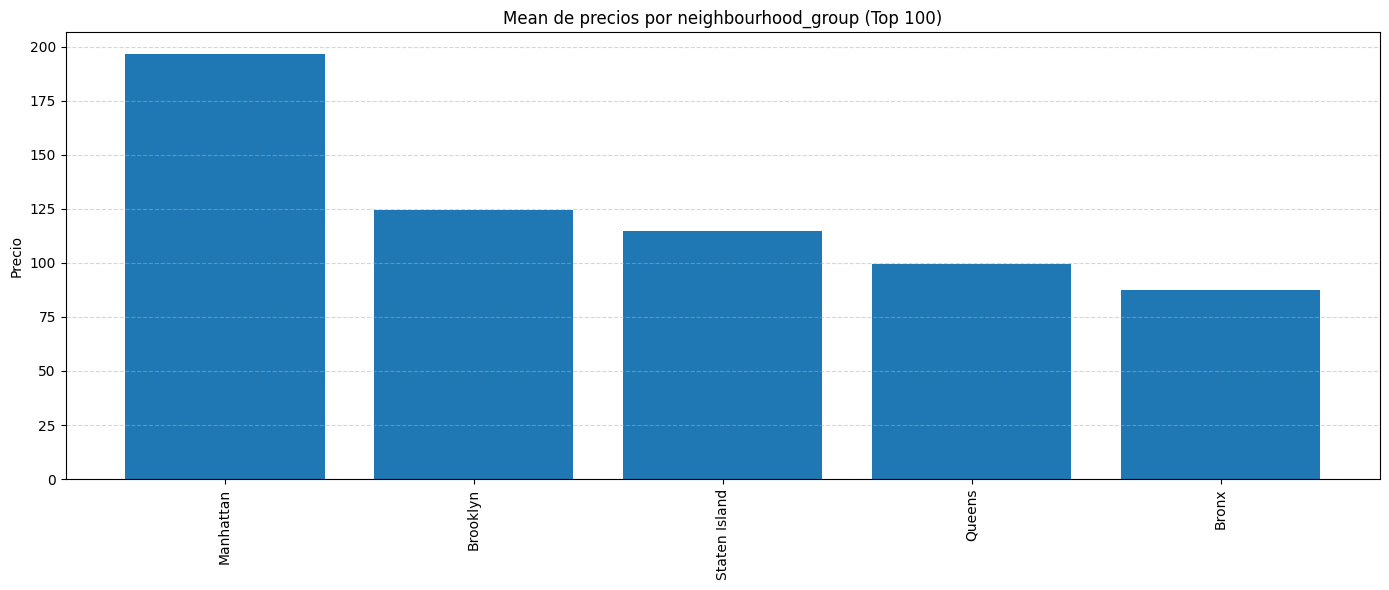

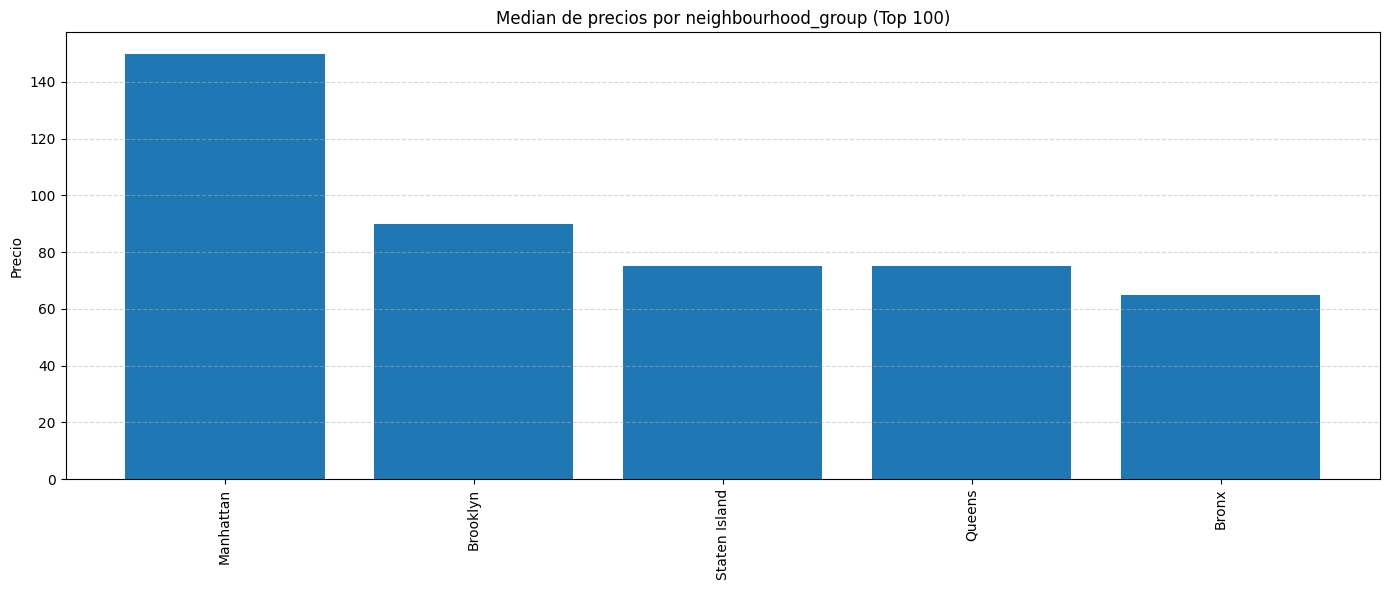

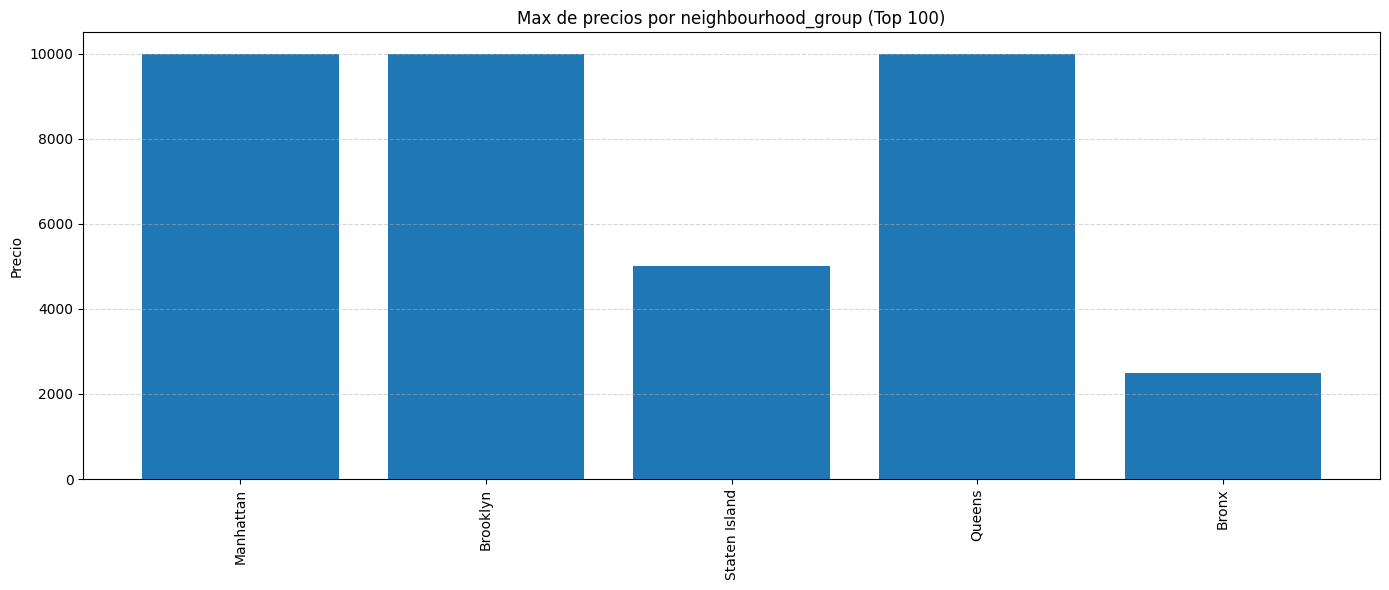

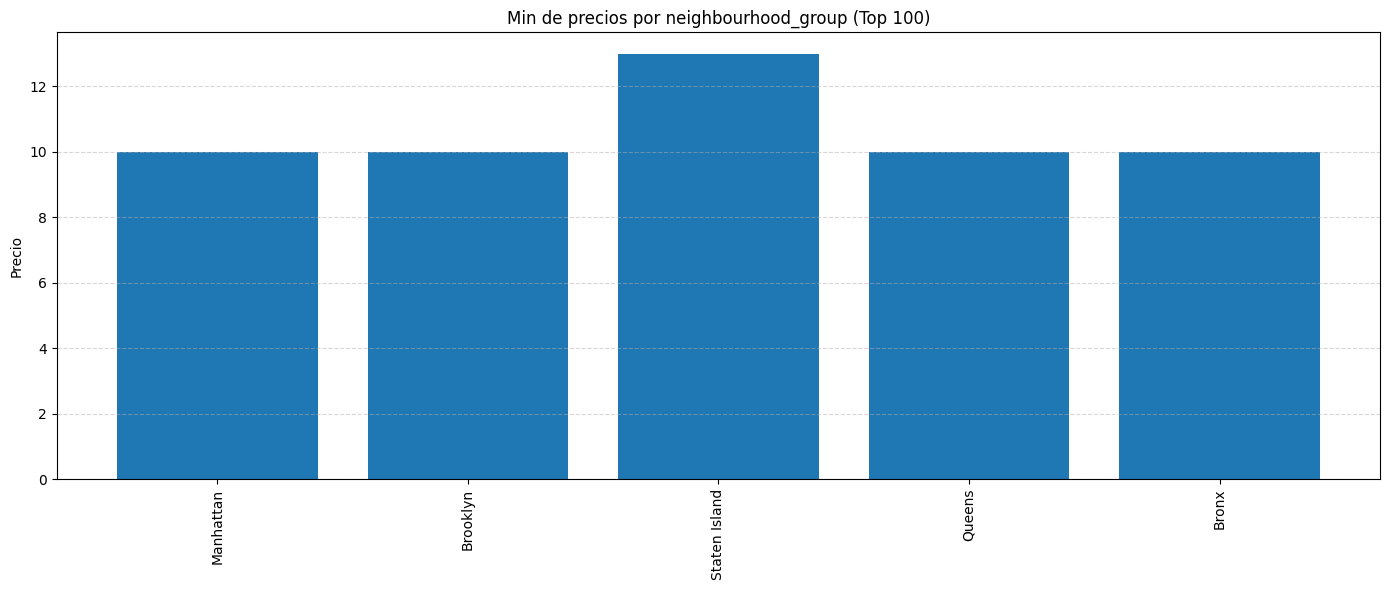

In [56]:
plot_price_stats(df_final, 'neighbourhood_group')


Para terminar, se hará de vuelta el gráfico del mapa, pero esta vez con la distribución de precios:

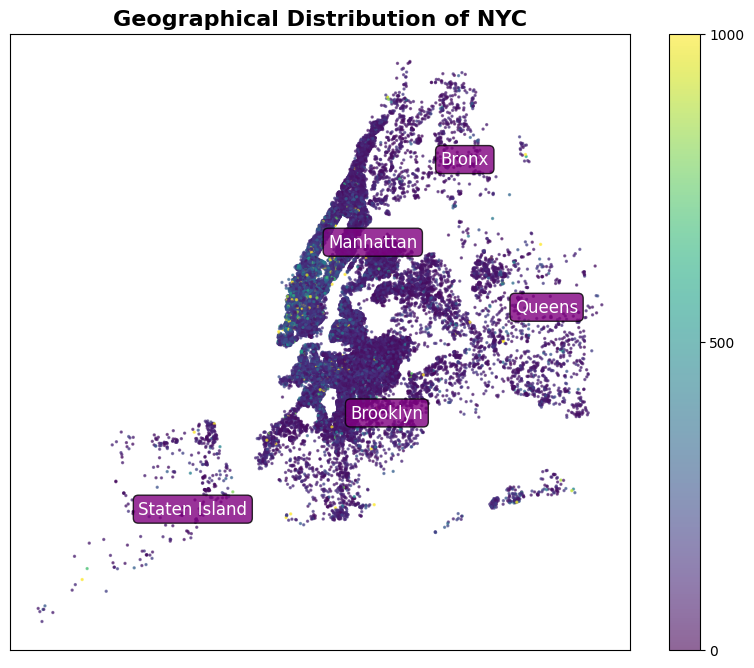

In [57]:
plot_map_with_prices(df_final)

In [ ]:
pd.save_csv("df_final.csv")